## Dataset Overview
HAM10000 ("Human Against Machine with 10000 training images") dataset - a large collection of multi-source dermatoscopic images of pigmented lesions

The dermatoscopic images are collected from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images.

It has 7 different classes of skin cancer which are listed below :
- Melanocytic nevi
- Melanoma
- Benign keratosis-like lesions
- Basal cell carcinoma
- Actinic keratoses
- Vascular lesions
- Dermatofibroma 

## Importing libraries

In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,KFold

import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score


## Reading the Data

In [32]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


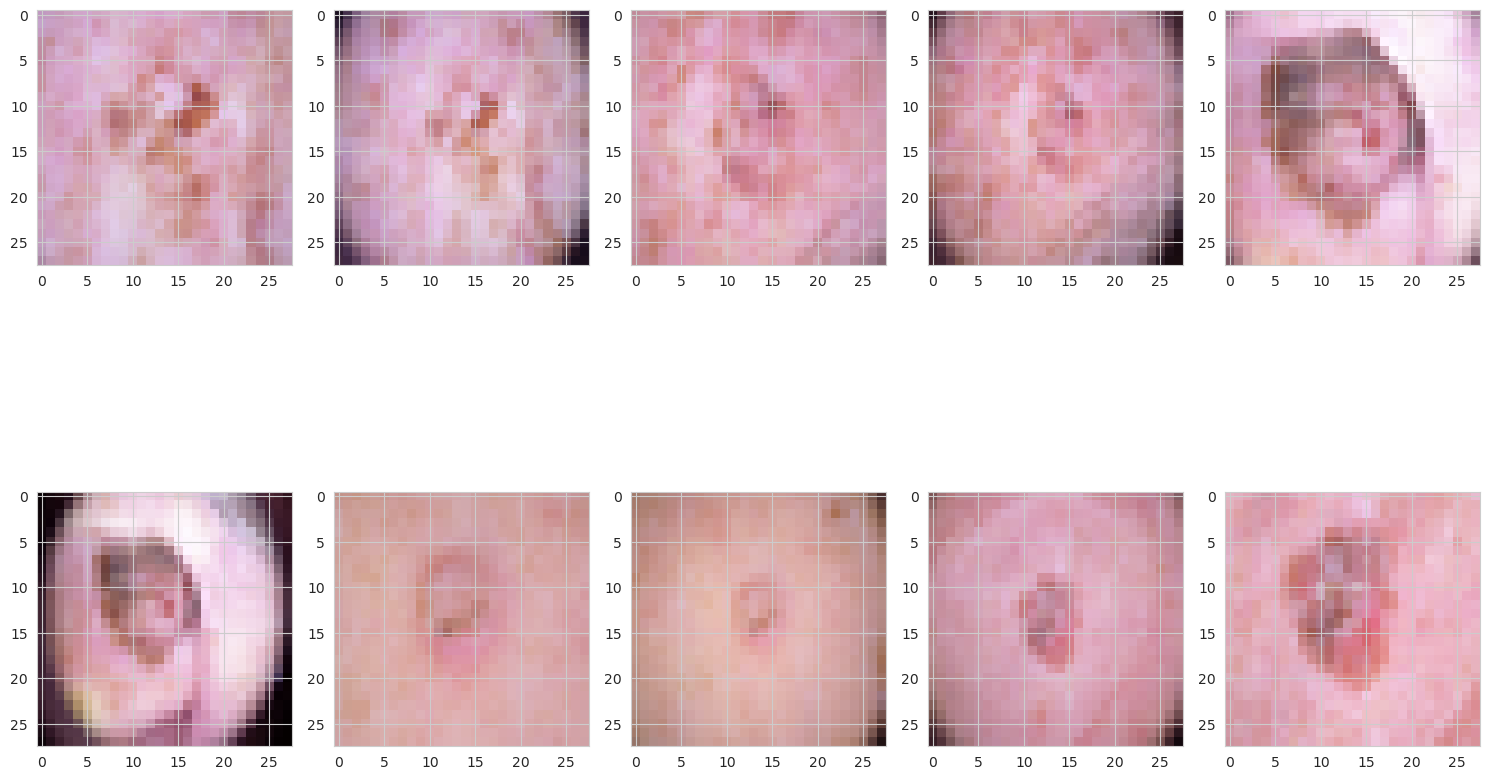

In [33]:
f , ax = plt.subplots(2,5)
f.set_size_inches(15, 15)
k = 0
y1 = data['label']
x1 = data.drop(columns = ['label'])
x1= np.array(x1).reshape(-1,28,28,3)
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x1[k].reshape(28,28,3))
#         ax[i, j].set_title(f"Image {Y_train[4]}")
        k = k + 1
    plt.tight_layout()

## Data Preprocessing
## Data Cleaning

In [34]:
data['label'].unique()
y = data['label']
x = data.drop(columns = ['label'])
data.isnull().sum().sum() #no null values present

0

In [35]:
meta_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [36]:
meta_data['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [37]:
data.isnull().sum().sum() #no null values present
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Exploratory Data Analysis

Text(0.5, 1.0, 'Frequency Distribution of Classes')

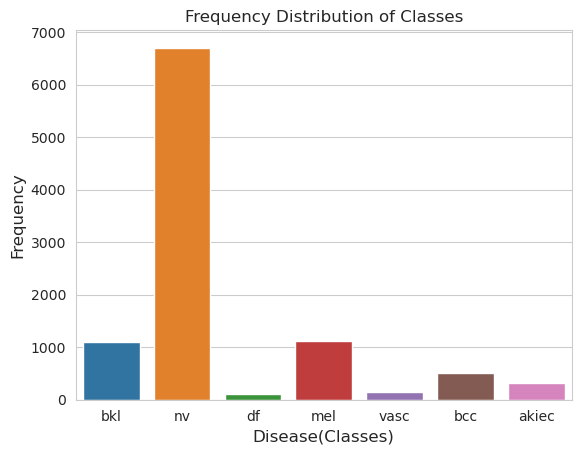

In [38]:
sns.countplot(x = 'dx', data = meta_data)
plt.xlabel('Disease(Classes)', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes')

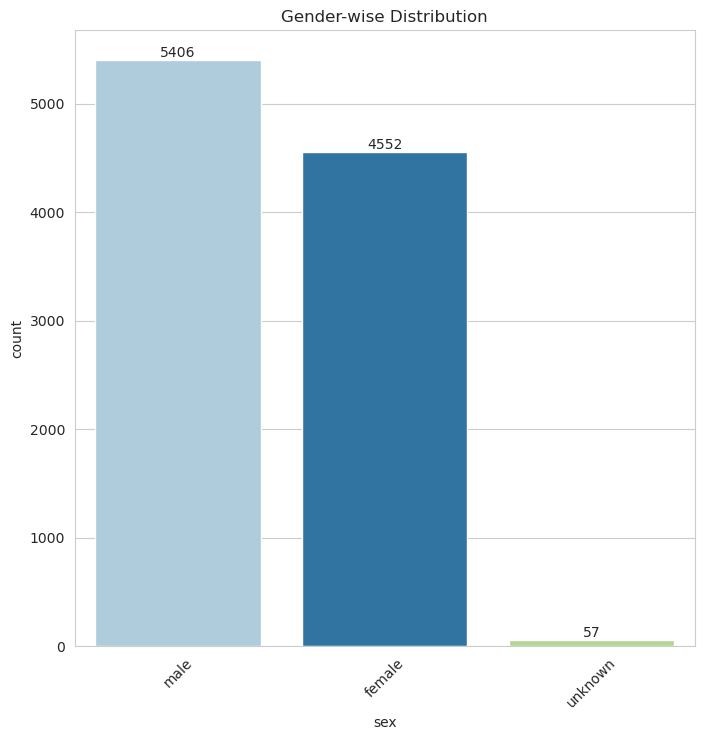

In [39]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(8,8))

ax = sns.countplot(x='sex',data=meta_data, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

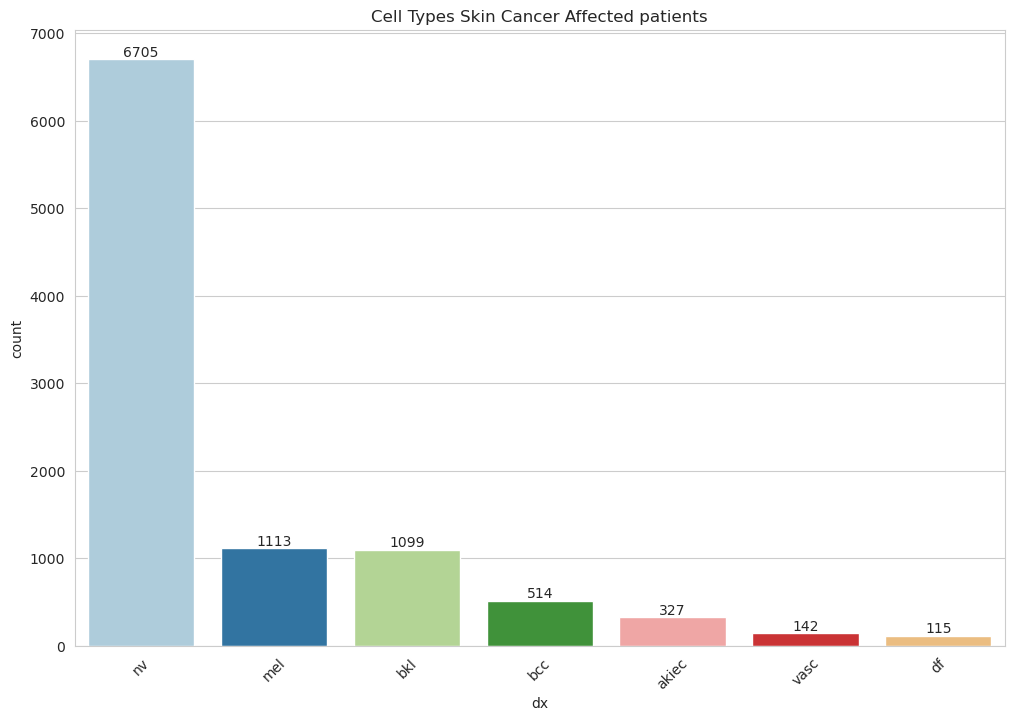

In [40]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

In [41]:
classes = {2:'bkl', 4:'nv', 3:'df', 6:'mel', 5:'vasc', 1:'bcc', 0:'akiec'}

classes_labels=[]
for key in classes.keys():
    classes_labels.append(key)
print(classes_labels)

[2, 4, 3, 6, 5, 1, 0]


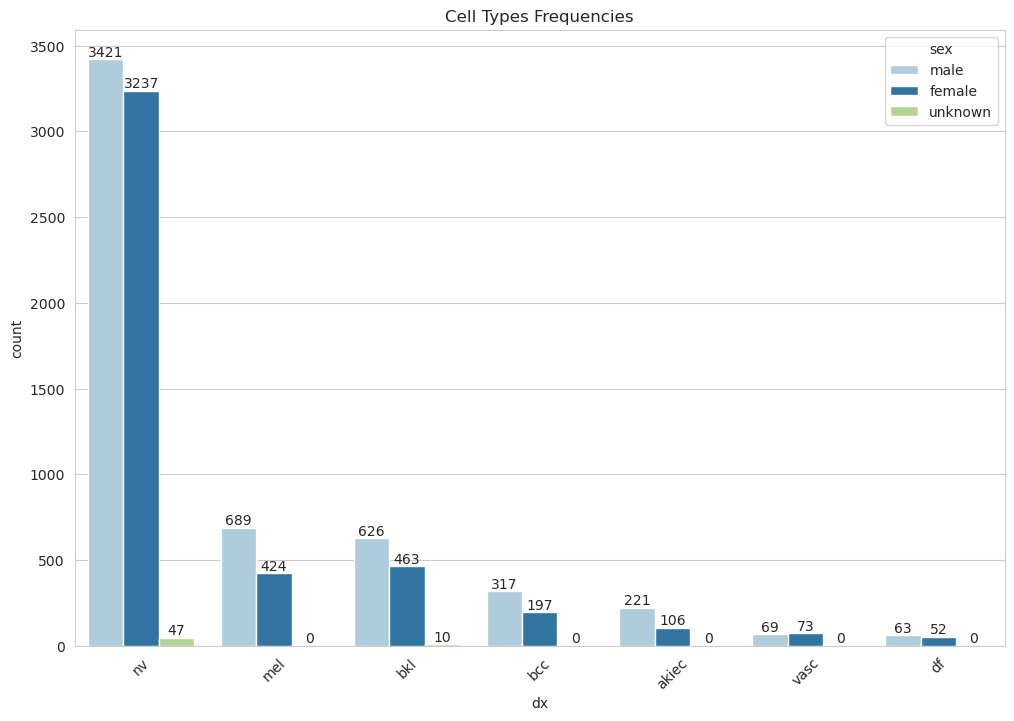

In [42]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx',hue='sex', data=meta_data, order = meta_data['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

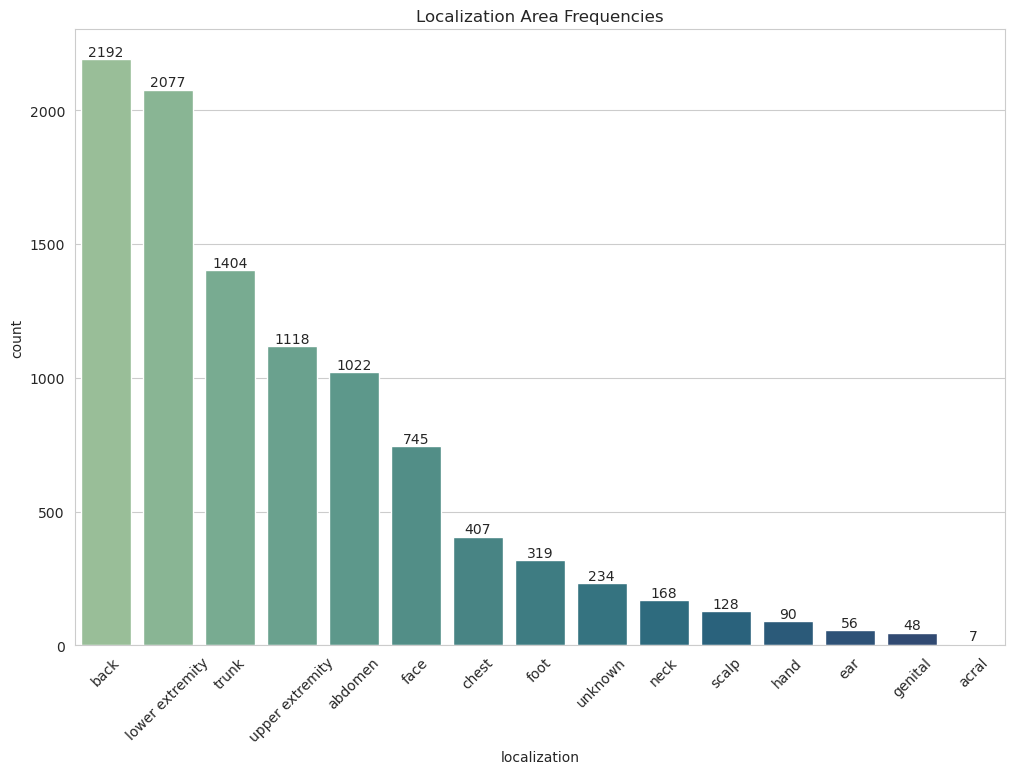

In [43]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=meta_data, order = meta_data['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

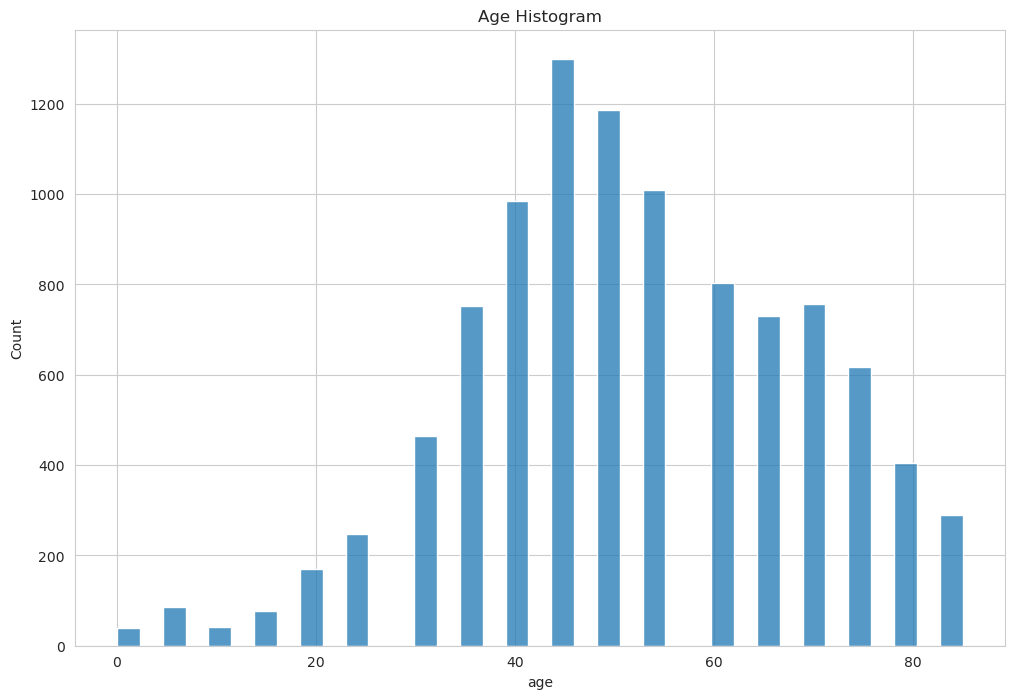

In [44]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age')
plt.title('Age Histogram')
plt.show()

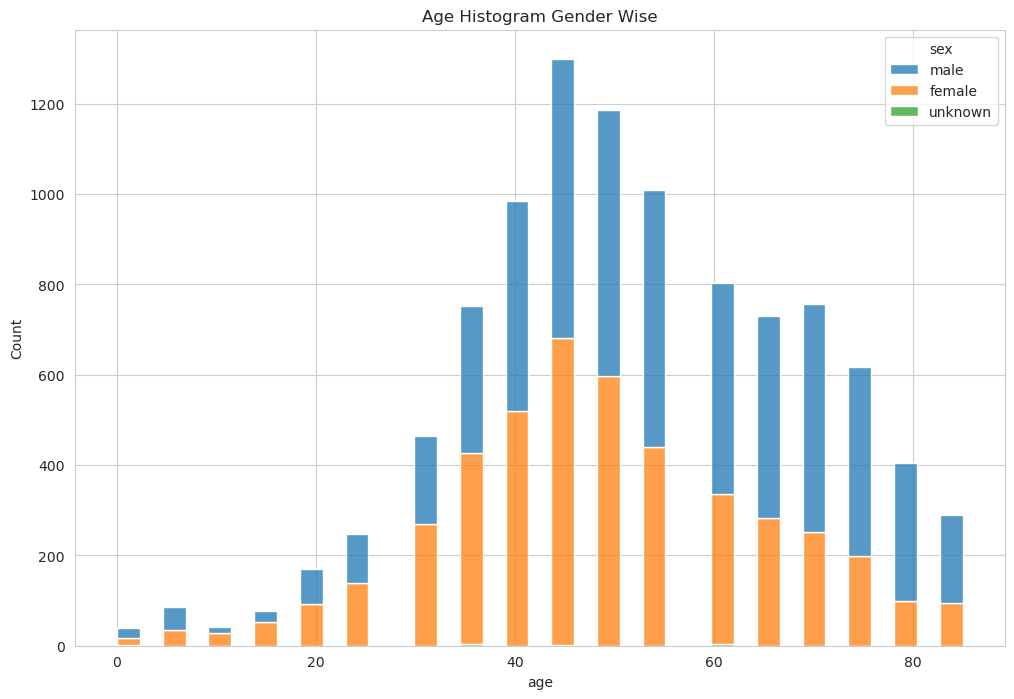

In [45]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=meta_data, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise')
plt.show()

In [46]:
print(x.shape,y.shape)
# To overcome class imbalace
oversample = RandomOverSampler()
Data,Label  = oversample.fit_resample(x,y)
print(Data.shape,Label.shape)

(10015, 2352) (10015,)
(46935, 2352) (46935,)


In [47]:
# reshaping the data so that it can be taken by convolution neural network(without disturbing the no. of samples)
Data= np.array(Data).reshape(-1,28,28,3)
print('Shape of X :',Data.shape)
print('Shape of y :',Label.shape)

Shape of X : (46935, 28, 28, 3)
Shape of y : (46935,)


In [48]:
print(Label)

0        2
1        2
2        2
3        2
4        2
        ..
46930    6
46931    6
46932    6
46933    6
46934    6
Name: label, Length: 46935, dtype: int64


In [49]:
newLabel = []

for i in range(len(Label)):
    for key in classes.keys():
        if Label[i] == key:
            newLabel.append(classes[key])

newLabel[46930]


'mel'

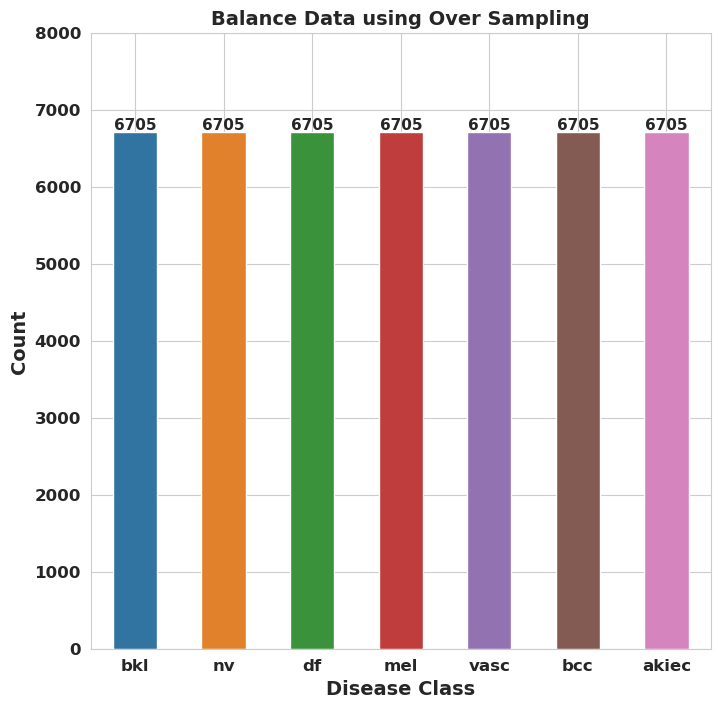

In [50]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(8,8))
ax = sns.countplot(x=newLabel,data=data,width=0.5)
for container in ax.containers:
    ax.bar_label(container, fontweight='bold', fontsize=11)
plt.title('Balance Data using Over Sampling', fontweight='bold', fontsize=14)
plt.ylim(0, 8000)
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel("Count",fontweight='bold', fontsize=14)
plt.xlabel("Disease Class", fontweight='bold', fontsize=14)

plt.grid(linewidth=0.8)
plt.show()

In [51]:
Data = np.array(Data).reshape(-1,28,28,3)
print('Shape of X :',Data.shape)
print('Shape of y :',Label.shape)

Shape of X : (46935, 28, 28, 3)
Shape of y : (46935,)


In [52]:
# Splitting Data
X_train, X_test, Y_train, Y_test = train_test_split(Data,Label, test_size=0.2, random_state=1)
print(X_train.shape,Y_train.shape)
print(X_test.shape , Y_test.shape)

(37548, 28, 28, 3) (37548,)
(9387, 28, 28, 3) (9387,)


In [53]:
classes = {4:'melanocytic nevi',
6: 'melanoma',
2:'benign keratosis-like lesions',
1:'basal cell carcinoma',
5:'pyogenic granulomas and hemorrhage',
0:'Actinic keratoses and intraepithelial carcinomae',
3:'dermatofibroma'}


In [54]:
Y_train[:10]

18033    1
38412    5
26590    2
6910     4
37704    5
15663    0
31556    3
45531    6
24641    2
44902    6
Name: label, dtype: int64

In [55]:
l_train = np.array(Y_train)
l_train[1]

5

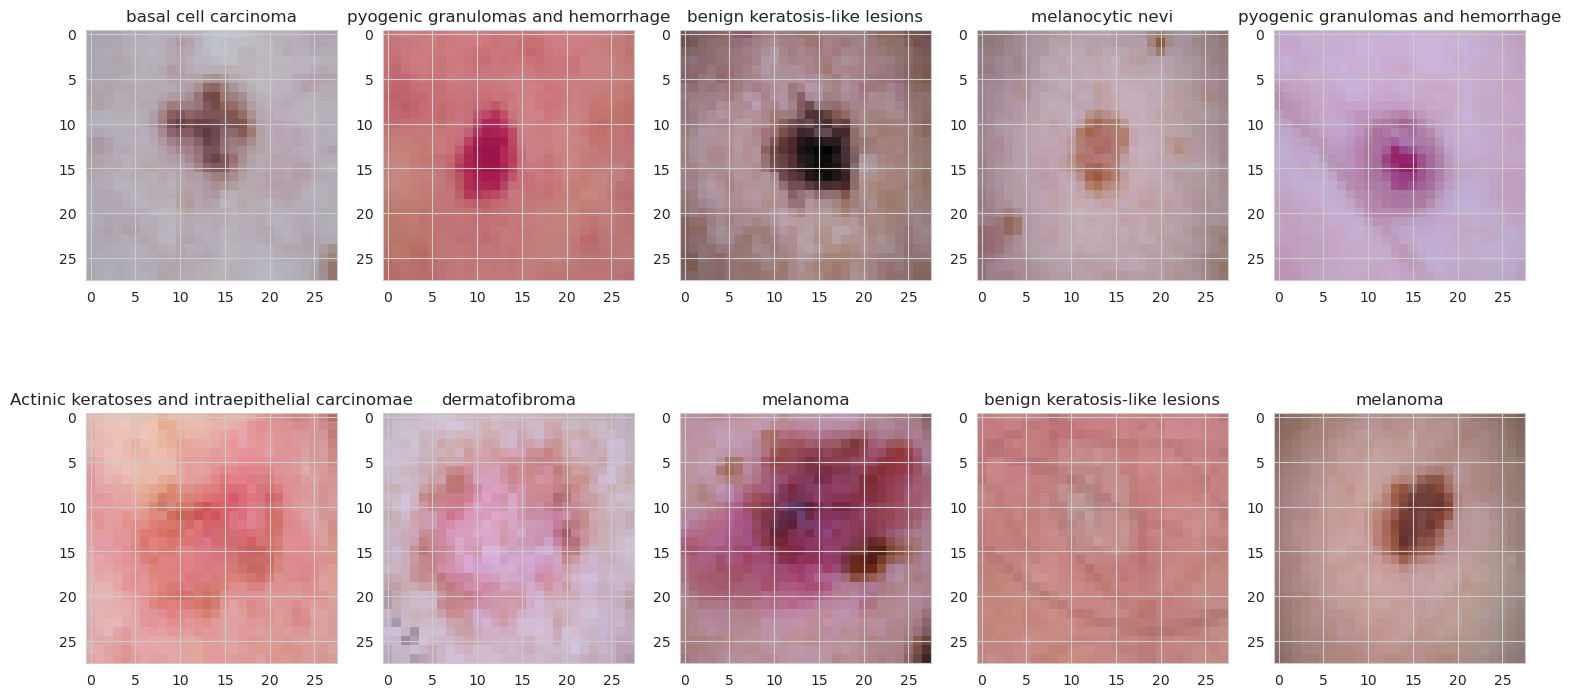

In [56]:
f , ax = plt.subplots(2,5)
f.set_size_inches(15, 15)
k = 0
l_train = np.array(Y_train)
for i in range(2):
    for j in range(5):
        plt.subplots_adjust(wspace=5)
        ax[i,j].imshow(X_train[k].reshape(28,28,3))
        ax[i, j].set_title(f"{classes[l_train[k]]}")
        k = k + 1
   
    plt.tight_layout()

In [57]:
model_CNN = Sequential()
model_CNN.add(Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())


model_CNN.add(MaxPool2D(pool_size = (2,2)))


model_CNN.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model_CNN.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_CNN.add(BatchNormalization())

model_CNN.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

model_CNN.add(Flatten())


model_CNN.add(Dense(64, activation = 'relu'))
model_CNN.add(BatchNormalization())


model_CNN.add(Dense(32))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(16))
model_CNN.add(Activation(activation='relu'))
model_CNN.add(BatchNormalization())

model_CNN.add(Dense(7))
model_CNN.add(Activation(activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model_CNN.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
print(model_CNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [58]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
history = model_CNN.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = 50,
                    callbacks = [reduce_lr, early_stop])

Epoch 1/50
470/470 [==============================] - 9s 9ms/step - loss: 1.0044 - accuracy: 0.6432 - val_loss: 0.7764 - val_accuracy: 0.7091 - lr: 0.0010
Epoch 2/50
470/470 [==============================] - 4s 8ms/step - loss: 0.4632 - accuracy: 0.8415 - val_loss: 0.8838 - val_accuracy: 0.6871 - lr: 0.0010
Epoch 3/50
470/470 [==============================] - 4s 8ms/step - loss: 0.2989 - accuracy: 0.8958 - val_loss: 0.6778 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 4/50
470/470 [==============================] - 4s 8ms/step - loss: 0.2196 - accuracy: 0.9224 - val_loss: 1.0653 - val_accuracy: 0.6581 - lr: 0.0010
Epoch 5/50
470/470 [==============================] - 4s 8ms/step - loss: 0.1689 - accuracy: 0.9410 - val_loss: 0.3811 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 6/50
470/470 [==============================] - 5s 10ms/step - loss: 0.1274 - accuracy: 0.9568 - val_loss: 0.5980 - val_accuracy: 0.8057 - lr: 0.0010
Epoch 7/50
470/470 [==============================] - 4s 8ms/step - l

In [59]:
results = model_CNN.evaluate(X_test , Y_test, verbose=0)

print("CNN Model Test Results")
print("        Test Loss: {:.5f}".format(results[0]))
print("    Test Accuracy: {:.2f}%".format(results[1] * 100))

CNN Model Test Results
        Test Loss: 0.07440
    Test Accuracy: 98.08%


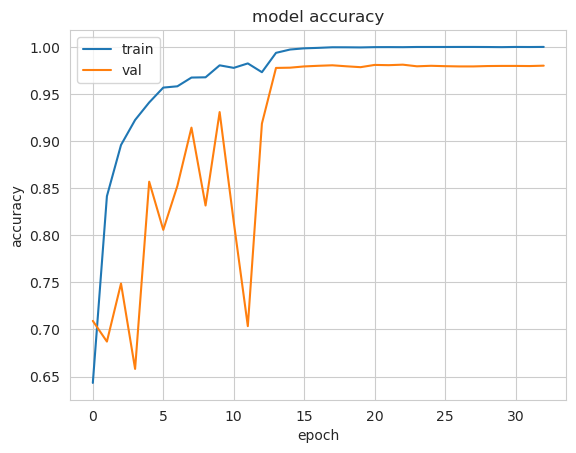

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

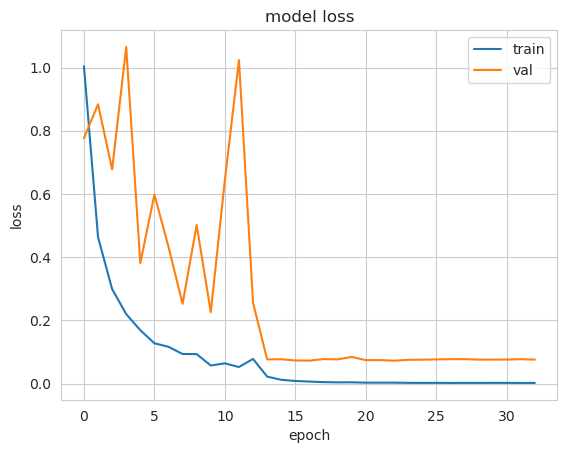

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix , classification_report

y_true_CNN = list(Y_test)
y_pred_CNN = model_CNN.predict(X_test)
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("Predicting First Ten Rows:")
print('Y Actual Values :' , y_true_CNN[0:10])
print('Y Predicted Values :' , y_pred_CNN[0:10])

294/294 [==============================] - 1s 2ms/step
Predicting First Ten Rows:
Y Actual Values : [5, 1, 4, 0, 5, 0, 2, 0, 3, 2]
Y Predicted Values : [5, 1, 4, 0, 5, 0, 2, 0, 3, 2]


[[1251    8    0    3    0    0    0]
 [  59 1221    3   70    4   12    5]
 [   0    0 1351    0    0    0    0]
 [   0   12    0 1349    3    1    0]
 [   0    0    0    0 1358    0    0]
 [   0    0    0    0    0 1318    0]
 [   0    0    0    0    0    0 1359]]


<AxesSubplot:>

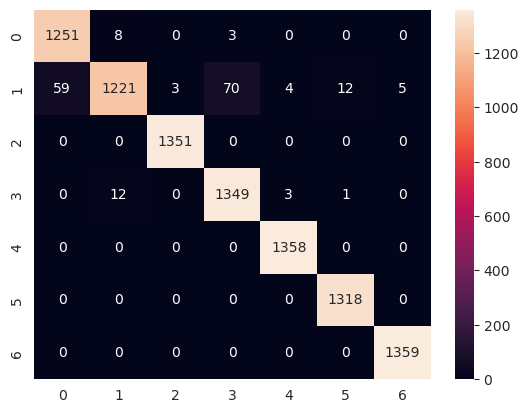

In [63]:
cm_CNN = confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels)
print(confusion_matrix(y_true_CNN,y_pred_CNN,labels=classes_labels))
sns.heatmap(cm_CNN, annot = True, fmt='')

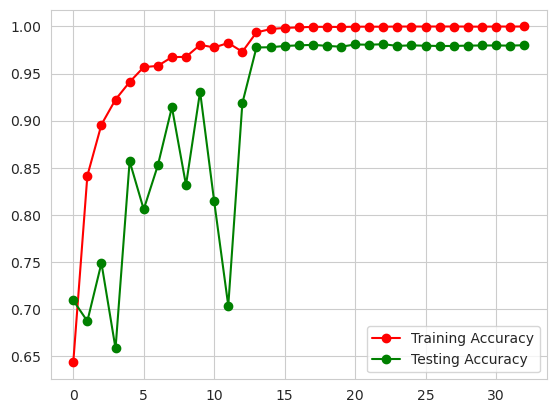

In [64]:
#training acc vs testing acc graph
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

In [65]:
#predicting
y_pred_CNN  = model_CNN.predict(X_test)
target_names = [f"{classes[i]}" for i in range(7)]
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("CNN Model Prediction Results")
print(classification_report(Y_test , y_pred_CNN,target_names=target_names))

294/294 [==============================] - 1s 2ms/step
CNN Model Prediction Results
                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       1.00      1.00      1.00      1359
                            basal cell carcinoma       0.99      1.00      1.00      1318
                   benign keratosis-like lesions       0.95      0.99      0.97      1262
                                  dermatofibroma       1.00      1.00      1.00      1351
                                melanocytic nevi       0.98      0.89      0.93      1374
              pyogenic granulomas and hemorrhage       0.99      1.00      1.00      1358
                                        melanoma       0.95      0.99      0.97      1365

                                        accuracy                           0.98      9387
                                       macro avg       0.98      0.98      0.98      9387
              

In [66]:
# Layers definitions
from keras import backend as K
for l in range(len(model_CNN.layers)):
    print(l, model_CNN.layers[l])

0 <keras.layers.convolutional.conv2d.Conv2D object at 0x7be998003350>
1 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7be938657e90>
2 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7be997db88d0>
3 <keras.layers.convolutional.conv2d.Conv2D object at 0x7be938637310>
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7be938623810>
5 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7be9385cd690>
6 <keras.layers.convolutional.conv2d.Conv2D object at 0x7be9385c6cd0>
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7be9385d7e50>
8 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7be9981c45d0>
9 <keras.layers.reshaping.flatten.Flatten object at 0x7be9385cd3d0>
10 <keras.layers.core.dense.Dense object at 0x7be9385fb310>
11 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7be9385e71d0>
12 <keras.layers.core.dense.Dense object at 0x7be9

In [67]:
model_CNN.layers[-2]

In [68]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


## Separating Features Layers from the CNN Model

In [69]:
import tensorflow as tf
# feature_extractor = tf.keras.Model(inputs=model_CNN.input, 
#                                     outputs=model_CNN.get_layer(-2).output)
# output_layers_model =tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.output)
# cnn_layer_output = model_CNN.layers[-2].output
# cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=cnn_layer_output)
cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.layers[-3].output)


## Extracting Features from CNN Model

In [70]:
# Extract features from input data using the CNN model
X_train_cnn = cnn_model_features.predict(X_train)
X_test_cnn = cnn_model_features.predict(X_test)

294/294 [==============================] - 1s 2ms/step


## Integrating CNN with SVM Classifier using Grid Search for Best Perameters

In [71]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

clf=SVC(kernel='rbf',C=100,gamma=0.001)
kf=KFold(n_splits=5)
scores_SVM = cross_val_score(clf, X_train_cnn, Y_train, cv=kf)
print(scores_SVM)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_SVM.mean(), scores_SVM.std()))
clf.fit(X_train_cnn, Y_train)
# Evaluate the combined CNN-SVM model on a test dataset
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)
y_testSVM = clf.predict(X_test_cnn)

[1.         0.99986684 1.         1.         0.98122253]
1.00 accuracy with a standard deviation of 0.01
SVM Accuracy: 98.87077873655055


In [72]:
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)


SVM Accuracy: 98.87077873655055


In [73]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_testSVM,target_names=target_names))
print("Accuracy: {0}".format(accuracy_score(Y_test, y_testSVM)*100))

                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       1.00      1.00      1.00      1359
                            basal cell carcinoma       1.00      1.00      1.00      1318
                   benign keratosis-like lesions       0.98      0.99      0.98      1262
                                  dermatofibroma       1.00      1.00      1.00      1351
                                melanocytic nevi       0.98      0.94      0.96      1374
              pyogenic granulomas and hemorrhage       1.00      1.00      1.00      1358
                                        melanoma       0.97      0.99      0.98      1365

                                        accuracy                           0.99      9387
                                       macro avg       0.99      0.99      0.99      9387
                                    weighted avg       0.99      0.99      0.99      9387

Accurac

## Integrating CNN with Random Forest Classifier using Grid Search for Best Perameters

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rgclf = RandomForestClassifier(max_depth=3,
               max_features=1,
               min_samples_split=3,
               bootstrap=False,
               criterion=  "entropy",
               n_estimators=20)
kf=KFold(n_splits=5)
scores_RF = cross_val_score(rgclf, X_train_cnn, Y_train, cv=kf)
print(scores_RF)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_RF.mean(), scores_RF.std()))
rgclf.fit(X_train_cnn, Y_train)
RFC_accuracy = rgclf.score(X_test_cnn, Y_test)
print('Random Forest Classifier Accuracy:', RFC_accuracy*100)
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))

[0.99720373 0.9976032  0.99533955 0.99826874 0.96990278]
0.99 accuracy with a standard deviation of 0.01
Random Forest Classifier Accuracy: 96.65494833280069
Accuracy: 96.65494833280069


In [75]:
y_test_RF = rgclf.predict(X_test_cnn)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_RF)*100))


Accuracy: 96.65494833280069


In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# parameters = {"n_neighbors": [1],
#               "weights": ['uniform', 'distance'],
#               "metric": ['minkowski','euclidean','manhattan'],
#               "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
kgclf = KNeighborsClassifier(n_neighbors=1,
              weights='distance',
              metric='euclidean',
              algorithm= 'auto')
kf=KFold(n_splits=5)
scores_KNN = cross_val_score(kgclf, X_train_cnn, Y_train, cv=kf)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_KNN.mean(), scores_KNN.std()))
kgclf.fit(X_train_cnn, Y_train)
KNN_accuracy = kgclf.score(X_test_cnn, Y_test)
print('KNN Classifier Accuracy:', KNN_accuracy*100)

1.00 accuracy with a standard deviation of 0.01
KNN Classifier Accuracy: 99.12645147544477


In [77]:
y_testKNN = kgclf.predict(X_test_cnn)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_testKNN,target_names=target_names))
print("Accuracy Score: {0}".format(accuracy_score(Y_test, y_testKNN)*100))

                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       1.00      1.00      1.00      1359
                            basal cell carcinoma       0.99      1.00      1.00      1318
                   benign keratosis-like lesions       0.98      1.00      0.99      1262
                                  dermatofibroma       1.00      1.00      1.00      1351
                                melanocytic nevi       1.00      0.94      0.97      1374
              pyogenic granulomas and hemorrhage       1.00      1.00      1.00      1358
                                        melanoma       0.97      1.00      0.99      1365

                                        accuracy                           0.99      9387
                                       macro avg       0.99      0.99      0.99      9387
                                    weighted avg       0.99      0.99      0.99      9387

Accurac

## Integrating CNN with Logistic Regression Classifier using Grid Search for Best Perameters

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



# Create a logistic regression object
grid_search_LR = LogisticRegression(C=100,
              penalty='l2')
kf=KFold(n_splits=5)
scores_LR = cross_val_score(grid_search_LR, X_train_cnn, Y_train, cv=kf)
print(scores_LR)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_LR.mean(), scores_LR.std()))
# Perform grid search with 5-fold cross-validation
grid_search_LR.fit(X_train_cnn, Y_train)

# Print the best hyperparameters and the corresponding accuracy score
y_test_LR = grid_search_LR.predict(X_test_cnn)

print(classification_report(Y_test, y_test_LR,target_names=target_names))
print("Accuracy: {0}".format(accuracy_score(Y_test, y_test_LR)*100))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[1.         1.         1.         1.         0.98108936]
1.00 accuracy with a standard deviation of 0.01
                                                  precision    recall  f1-score   support

Actinic keratoses and intraepithelial carcinomae       1.00      1.00      1.00      1359
                            basal cell carcinoma       1.00      1.00      1.00      1318
                   benign keratosis-like lesions       0.97      0.99      0.98      1262
                                  dermatofibroma       1.00      1.00      1.00      1351
                                melanocytic nevi       0.98      0.94      0.96      1374
              pyogenic granulomas and hemorrhage       1.00      1.00      1.00      1358
                                        melanoma       0.97      0.99      0.98      1365

                                        accuracy                           0.99      9387
                                       macro avg       0.99      0.99      0.99    

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
